In [1]:
import tensorflow_quantum as tfq
import tensorflow as tf
import cirq
import sympy
import random
import matplotlib.pyplot as plt
import numpy as np

2024-01-11 10:44:41.994617: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/arturo/miniconda3/envs/tfv2/lib/:/lib:
2024-01-11 10:44:41.994650: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-11 10:44:41.994665: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arturo-virtual-machine): /proc/driver/nvidia/version does not exist
2024-01-11 10:44:41.995069: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def make_data(n1, n2):
    qubit = cirq.GridQubit(0,0)
    train, test = [], []
    train_label, test_label = [], []
    for _ in range(n1):
        cir = cirq.Circuit()
        rot = random.uniform(0,0.1) if random.random() < 0.5 else random.uniform(0.9,1)
        cir.append([cirq.X(qubit)**rot])
        train.append(cir)
        if rot < 0.5:
            train_label.append(1)
        else:
            train_label.append(-1)
    for _ in range(n2):
        cir = cirq.Circuit()
        rot = random.uniform(0,0.1) if random.random() < 0.5 else random.uniform(0.9,1)
        cir.append([cirq.X(qubit)**rot])
        test.append(cir)
        if rot < 0.5:
            test_label.append(1)
        else:
            test_label.append(-1)
    return tfq.convert_to_tensor(train), np.array(train_label), tfq.convert_to_tensor(test), np.array(test_label)

In [3]:
def make_circuit(qubit):
    x = sympy.symbols('X_rot')
    y = sympy.symbols('Y_rot')
    z = sympy.symbols('Z_rot')
    c = cirq.Circuit()
    c.append(cirq.rx(x).on(qubit))
    c.append(cirq.ry(y).on(qubit))
    c.append(cirq.rz(z).on(qubit))
    return c

In [4]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [5]:
train, train_label, test, test_label = make_data(1000, 100)

In [6]:
qubit = cirq.GridQubit(0,0)
readout_operators = [cirq.X(qubit)]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
trial_circuit = make_circuit(qubit)
print(trial_circuit)
layer1 = tfq.layers.PQC(make_circuit(qubit), readout_operators, repetitions=32, differentiator=tfq.differentiators.ParameterShift(), initializer=tf.keras.initializers.Zeros)(inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=layer1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.hinge, metrics=[hinge_accuracy])

(0, 0): ───Rx(X_rot)───Ry(Y_rot)───Rz(Z_rot)───


In [7]:
history = model.fit(train, train_label, epochs=64, batch_size=32, validation_data=(test, test_label))

Epoch 1/64
32/32 [==============================] - 2s 30ms/step - loss: 0.9815 - hinge_accuracy: 0.5410 - val_loss: 0.9625 - val_hinge_accuracy: 0.6094
Epoch 2/64
32/32 [==============================] - 1s 17ms/step - loss: 0.9528 - hinge_accuracy: 0.6143 - val_loss: 0.9613 - val_hinge_accuracy: 0.5938
Epoch 3/64
32/32 [==============================] - 1s 16ms/step - loss: 0.9230 - hinge_accuracy: 0.6777 - val_loss: 0.9219 - val_hinge_accuracy: 0.5625
Epoch 4/64
32/32 [==============================] - 1s 16ms/step - loss: 0.9000 - hinge_accuracy: 0.7168 - val_loss: 0.8712 - val_hinge_accuracy: 0.8203
Epoch 5/64
32/32 [==============================] - 1s 16ms/step - loss: 0.8422 - hinge_accuracy: 0.8105 - val_loss: 0.8325 - val_hinge_accuracy: 0.7578
Epoch 6/64
32/32 [==============================] - 1s 16ms/step - loss: 0.7983 - hinge_accuracy: 0.8750 - val_loss: 0.7625 - val_hinge_accuracy: 0.9531
Epoch 7/64
32/32 [==============================] - 1s 16ms/step - loss: 0.7584 - 

In [8]:
print(model.trainable_weights)

[<tf.Variable 'parameters:0' shape=(3,) dtype=float32, numpy=array([-1.519323  ,  0.74180794, -1.5238483 ], dtype=float32)>]


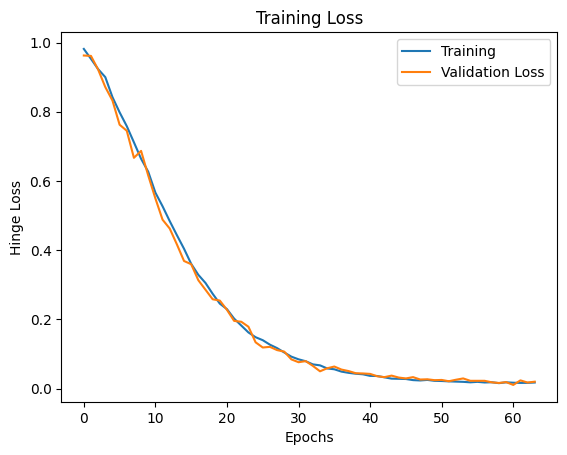

In [9]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Hinge Loss")
plt.show()


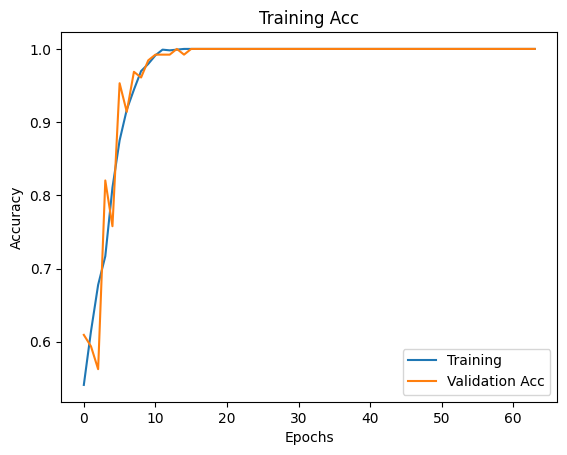

In [10]:
plt.plot(history.history['hinge_accuracy'], label='Training')
plt.plot(history.history['val_hinge_accuracy'], label='Validation Acc')
plt.legend()
plt.title("Training Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()